# Using regression for lane following and localization

MAC0318 - Introduction to Mobile Robot Programming

EP8 - Localization and regression

## Introduction and motivation

The objective of this Notebook is to train a model that reliably predicts the pose of the agent on a lane through the use of the robot's front camera. The agent must be able to take a snapshot of the current timestep front camera image, and with that predict the robot's pose in relation to the road tile it is currently standing on.

The robot's pose consists of two parameters: a distance $d$ of the robot with respect to the ideal robot's position, and a $\phi$ consisting of the sine of the angle between the ideal direction vector and the current direction vector. The figure below, originally from Duckietown's slides, illustrates the problem.

![Lane localization](https://www.ime.usp.br/~renatolg/mac0318/lane_localization.png)

Ideally we want the robot to be on the center of the right lane, i.e. $d=0$; and have a $\phi$ value of zero, which basically means the angle difference between the current direction vector and the vector representing the tangent of the ideal road "curve" is zero, i.e. they are both equal.

However, we do not have these measurements ($d$ and $\phi$) in the real world. If we did, the problem of lane following would be already solved. What we need is to predict both these values from the front camera image, which is the only input we have. Given a dataset of thousands of values of $d$ and $\phi$ coupled with their corresponding camera images at that timestep, we wish to train a model that reliably predicts our localization on the lane.

This is a regression task, as we wish to most closely approach our model to that of the "real function" that correlates the tuple $(d, \phi, I)$, where $I$ is the front camera image. We will achieve this function approximation through the use of multilayer perceptrons (MLPs) and convolutional neural networks (CNNs).

---

# Getting the dataset

As mentioned before, we need to train a model that predicts both $d$ and $\phi$ from an image. To do this we would ideally collect some data to train the model. This has already been done. The dataset we shall use can be found [here](https://www.ime.usp.br/~renatolg/mac0318/data_gray_120x160.npy). We extracted 3080 data points. Each data point consists of a tuple $(I, d, \phi)$, where $I$ is a $160\times 120$ 8-bit grayscale image; $d$ is the distance between the agent and the closest point to the ideal curve; and $\phi$ is the sine between the tangent of the ideal curve and the agent's real direction.

Our images were shrunk down and converted to grayscale because of memory issues. Had we not done that, the models would not be able to be trained on Colab's 12GB GPU. Originally, images were in $480\times 640$ RGB format, which is exactly the format we'd get if we were to extract directly from the Duckiebot's camera feed, both in the simulator and the real robot. With this in mind, let us make a mental note and remind ourselves later that, since we are training our model with pre-processed images, we should apply these same transformations when we do prediction and apply our model to the "real world".

Let's download the dataset.

In [1]:
ls && wget 'https://www.ime.usp.br/~renatolg/mac0318/data_gray_120x160.npy' && ls

sample_data/
--2019-09-08 23:09:10--  https://www.ime.usp.br/~renatolg/mac0318/data_gray_120x160.npy
Resolving www.ime.usp.br (www.ime.usp.br)... 143.107.45.22
Connecting to www.ime.usp.br (www.ime.usp.br)|143.107.45.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59508414 (57M)
Saving to: ‘data_gray_120x160.npy’

data_gray_120x160.n 100%[===================>]  56.75M  8.95MB/s    in 8.1s    

2019-09-08 23:09:20 (7.03 MB/s) - ‘data_gray_120x160.npy’ saved [59508414/59508414]

data_gray_120x160.npy  sample_data


Our dataset is now downloaded and ready to be processed. Let's import some libraries.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np

import matplotlib.pyplot as plt
import pandas
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Set some constants, namely image dimensions.

In [0]:
ORIG_IMAGE_DIMENSIONS = (480, 640)
ORIG_IMAGE_DIMENSIONS_N = ORIG_IMAGE_DIMENSIONS[0]*ORIG_IMAGE_DIMENSIONS[1]
IMAGE_DIMENSIONS = (120, 160)
IMAGE_DIMENSIONS_EXPANDED = (IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 1)
IMAGE_DIMENSIONS_N = IMAGE_DIMENSIONS[0]*IMAGE_DIMENSIONS[1]

Let's take a look at our dataset.

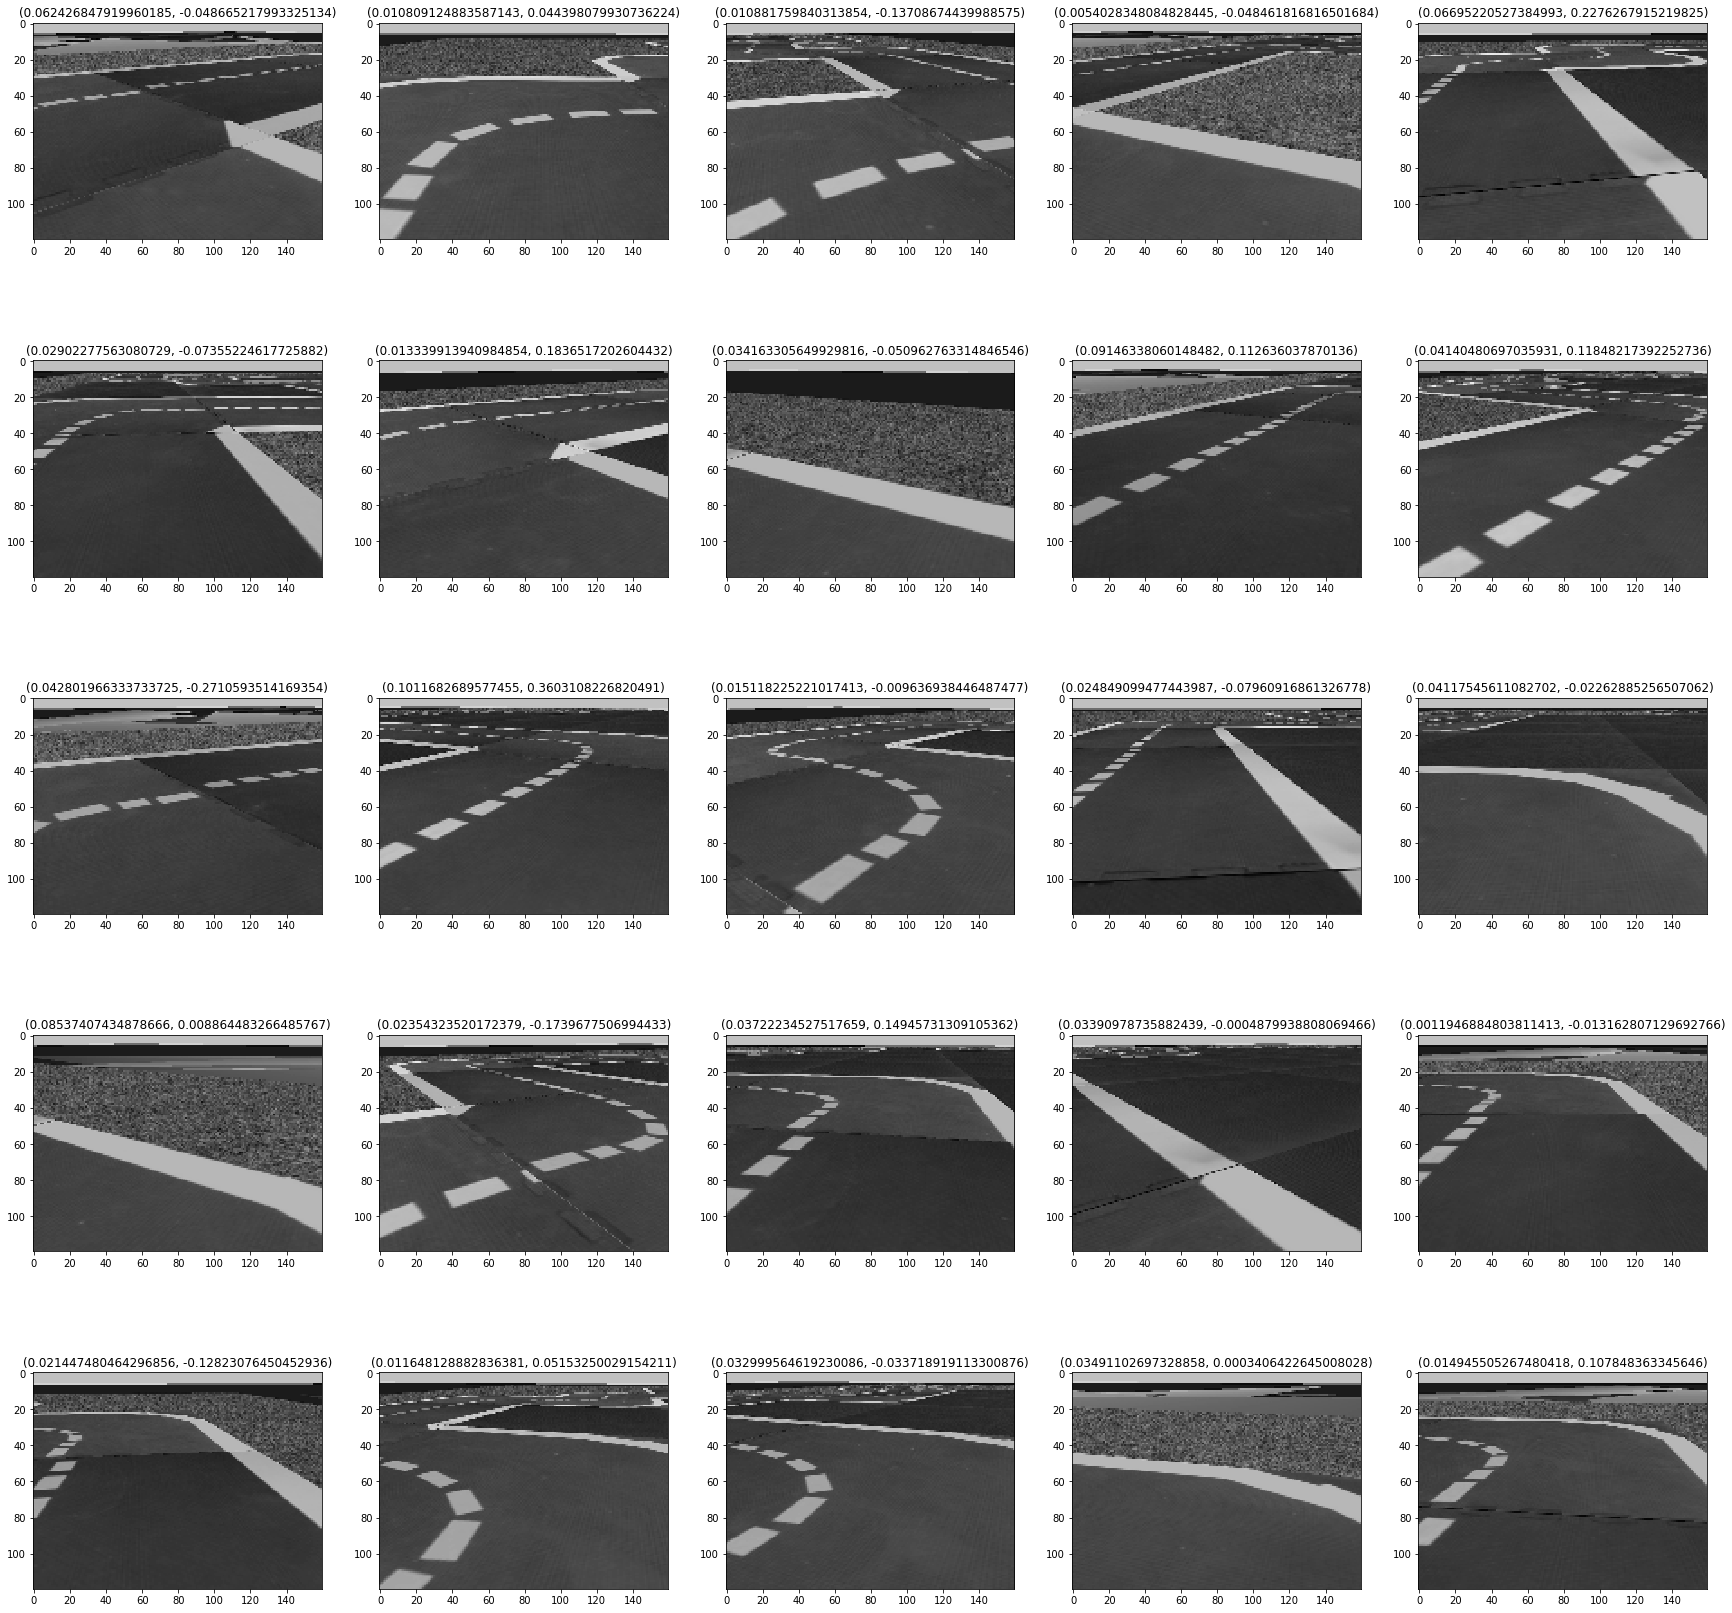

In [6]:
def visualize():
  import random
  rows, cols = 5, 5
  D = np.load('data_gray_120x160.npy', allow_pickle=True)
  S = [D[random.randint(0, len(D)-1)] for i in range(rows*cols)]
  plt.figure(figsize=(30, 30))
  for i, s in enumerate(S):
    plt.subplot(rows, cols, i+1).set_title("({}, {})".format(s[1], s[2]))
    plt.imshow(s[0], cmap='gray', vmin=0, vmax=255)
  plt.show()

visualize()

The figure above shows the downscaled grayscaled front camera images and their respective $(d, \phi)$ values.

---

## Manipulating our data

Once we've acquired our data, we need to first normalize our entries and then partition the dataset into two sets: training and testing. We do the former through the function `norm`.

To normalize we need to compute the mean, which we'll denote by $\mu$, and standard deviation, $\sigma$. This can easily be done if we have the data in the first place, for instance when we have our training dataset. But when we take our model to the real world, we won't know exactly what the mean and standard deviation of the track is going to look like. What we can do is assume that our training data's $\mu_r$ and $\sigma_r$ are meaningful in our real-world data. This is a huge assumption, but it's the best we can do if we have no data to go with. An alternative to this would be to sample from our real-world environment and iteratively update the mean and standard deviation from the real world $(\mu_w, \sigma_w)$ while we predict. This would eventually converge.

Partitioning the dataset into training and testing sets can be done through the `partition_data` function. It takes the raw dataset `D` and reserves a portion of $p$ percent of `D` for testing and $1-p$ for training.

In [0]:
# Normalize dataset.
def norm(x, mu=None, sigma=None):
  if mu is None:
    mu = x.mean()
  if sigma is None:
    sigma = x.std()
  return (x-mu)/sigma, mu, sigma

# Partitions dataset D into train and test sets with a percentage p. Returns four datasets: input
# train set, output train set, input test set, output test set.
def partition_data(D, p=0.3, rand=42):
  X, y = np.array(D[:,0].tolist()), np.squeeze(np.array(D[:,1:].tolist(), dtype=np.float))
  return train_test_split(X, y, test_size=0.3, random_state=rand)

---

## Creating our regression model

As mentioned earlier, we'll train an MLP and a CNN model for our regression problem. As the name suggests, an MLP is nothing more than a multi-layer perceptron. That is, several layers of fully connected perceptrons. We create our MLP model through the `mlp_model` function. It returns a neural network with $120\times 160=19200$ neurons for the input layer. The second layer is a fourth of that amount (4800 neurons), and the third is half the last (2400 neurons). The last, output layer consists of two neurons: one that outputs the distance $d$ and the other which models $\phi$. We use ReLU for all layers, and optimize with Adam by mean squared error (MSE). The MSE loss function is often used for regression tasks.

Our CNN works a bit differently. The first, input layer is a 2D convolutional layer. It contains 64 filters and has kernel (i.e. the convolution "window") size of 3. This layer is then followed by a 32 filter convolutional layer. Up to now we have our output in matrix form. We can flatten this representation through the `Flatten()` layer, which then passes the signals to a 256 neurons fully connected perceptron layer. Both our activation functions and loss are the same as our MLP model.

In [0]:
# MLP model.
def mlp_model():
  N = keras.Sequential([
    layers.Dense(IMAGE_DIMENSIONS_N, input_dim=IMAGE_DIMENSIONS_N, activation=tf.nn.relu),
    layers.Dense(IMAGE_DIMENSIONS_N//4, activation=tf.nn.relu),
    layers.Dense(IMAGE_DIMENSIONS_N//8, activation=tf.nn.relu),
    layers.Dense(2)
  ])
  N.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mean_absolute_error',
                                                                   'mean_squared_error'])
  return N

# CNN model.
def cnn_model():
  N = keras.Sequential([
    layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=IMAGE_DIMENSIONS_EXPANDED),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(2)
  ])
  N.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error',
                                                                  'mean_squared_error'])
  return N

---

## Plotting our results

Let's track our train and validation errors. The below function does exactly that, plotting both mean absolute error and mean square error as a function of number of epochs.

In [0]:
def plot_history(history):
  hist = pandas.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(30, 15))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()

  plt.figure(figsize=(30, 15))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.show()

---

## Training

To train our models, we have to partition our dataset, normalize inputs (in our case images), reshape them to fit our models (an MLP must take as input a flattened array representing our image, a CNN takes it as a matrix). We then create our Keras model and fit it to the given data. We'll use 20% percent of the training dataset as validation, and have a mini-batch size of 64. We'll then plot the epoch history, normalize our test set with the parameters we took from our train dataset, and then feed it to the model so we can properly evaluate our predictions.

In [0]:
def train(D, n_epochs=300, model='cnn'):
  print('Partitioning data...')
  X_r, X_t, Y_r, Y_t = partition_data(D)
  print('Normalizing training set...')
  if model == 'cnn':
    X_r, mu, sigma = norm(X_r)
    X_r = X_r.reshape(len(X_r), *IMAGE_DIMENSIONS_EXPANDED)
  else:
    X_r, mu, sigma = norm(X_r)
    X_r = X_r.reshape(len(X_r), IMAGE_DIMENSIONS_N)
  print(X_r.shape, Y_r.shape, X_t.shape, Y_t.shape)
  print('Generating model...')
  if model == 'cnn':
    N = cnn_model()
  else:
    N = mlp_model()
  print('Training...')
  H = N.fit(X_r, Y_r, epochs=n_epochs, validation_split=0.2, verbose=1, batch_size=64)
  print('Computing histogram...')
  hist = pandas.DataFrame(H.history)
  hist['epoch'] = H.epoch
  hist.tail()
  print('Plotting history...')
  plot_history(H)
  print('Normalizing test set...')
  if model == 'cnn':
    X_t, _, _ = norm(X_t, mu, sigma)
    X_t = X_t.reshape(len(X_t), *IMAGE_DIMENSIONS_EXPANDED)
  else:
    X_t, _, _ = norm(X_t, mu, sigma)
    X_t = X_t.reshape(len(X_t), IMAGE_DIMENSIONS_N)
  print('Evaluating model...')
  loss, mae, mse = N.evaluate(X_t, Y_t, verbose=1)
  print(loss, mae, mse)
  return N

---

## Results

Now we train our MLP and CNN models and evaluate which is better. We'll output them in `.h5` format so we can use them in our Duckietown simulator.

GPU Available:  True
Loading dataset...
Running MLP model...
Partitioning data...
Normalizing training set...
(2156, 19200) (2156, 2) (924, 120, 160) (924, 2)
Generating model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training...
Train on 1724 samples, validate on 432 samples
Epoch 1/300
1724/1724 [==============================] - 4s 2ms/sample - loss: 143114.4309 - mean_absolute_error: 73.9913 - mean_squared_error: 143114.4375 - val_loss: 88.5464 - val_mean_absolute_error: 2.0176 - val_mean_squared_error: 88.5464
Epoch 2/300
1724/1724 [==============================] - 3s 2ms/sample - loss: 42.9626 - mean_absolute_error: 1.1286 - mean_squared_error: 42.9626 - val_loss: 2.0830 - val_mean_absolute_error: 0.5024 - val_mean_squared_error: 2.0830
Epoch 3/300
1724/1724 [==============================] - 3s 2ms/sample - loss: 1.5158 - mean_absolute_error: 0.3082 - mean_squared_error: 1.5158 - val_loss: 0.3553 - v

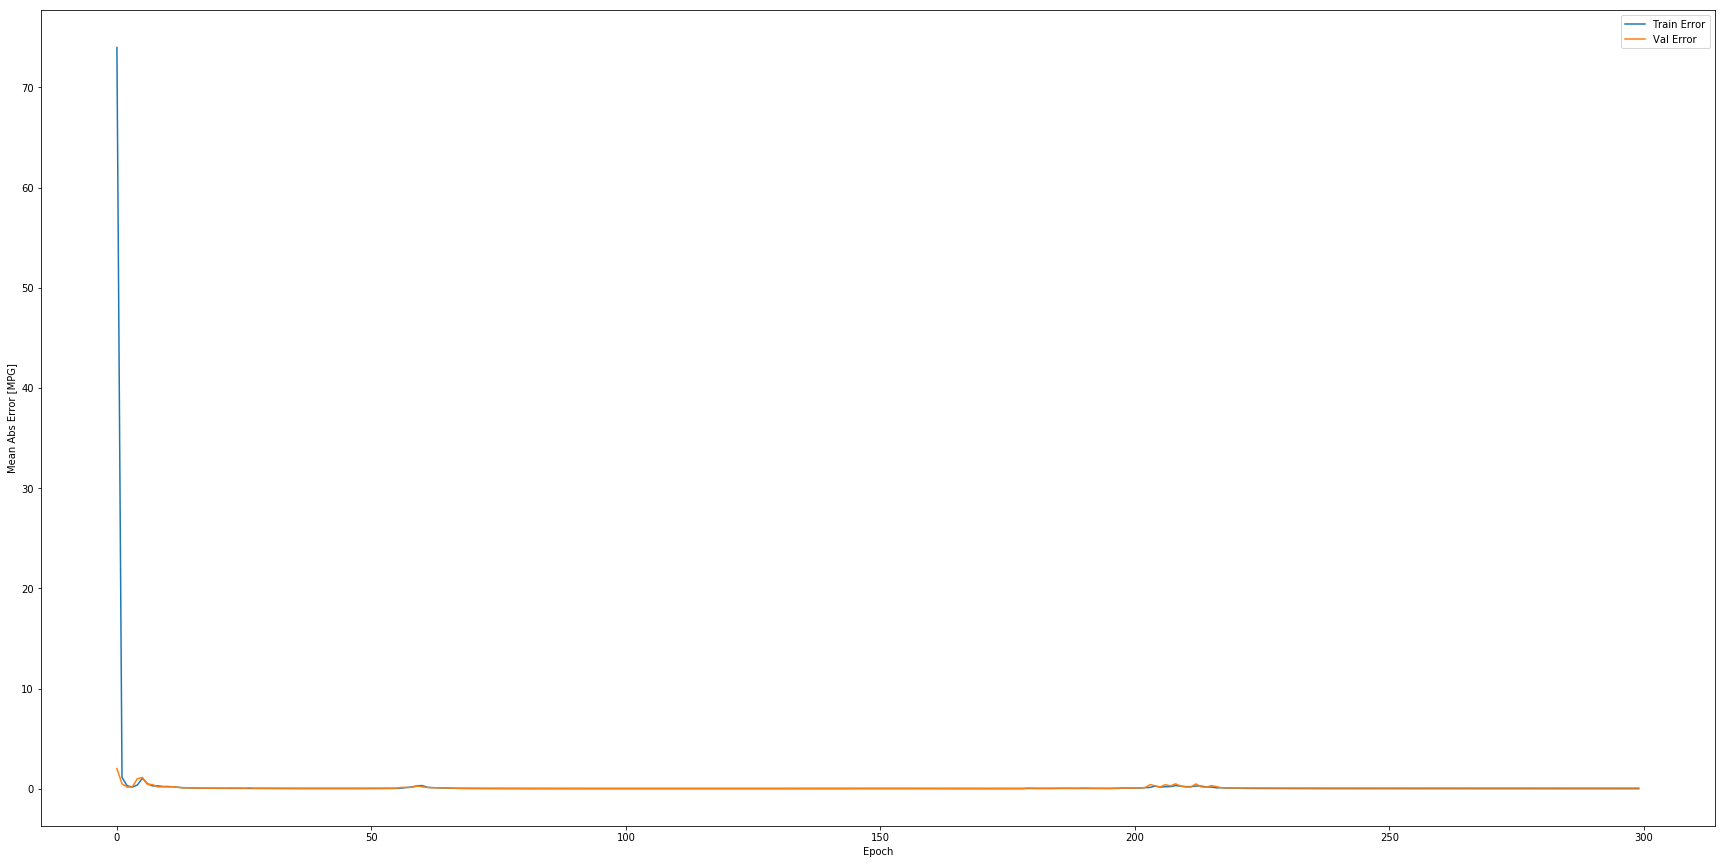

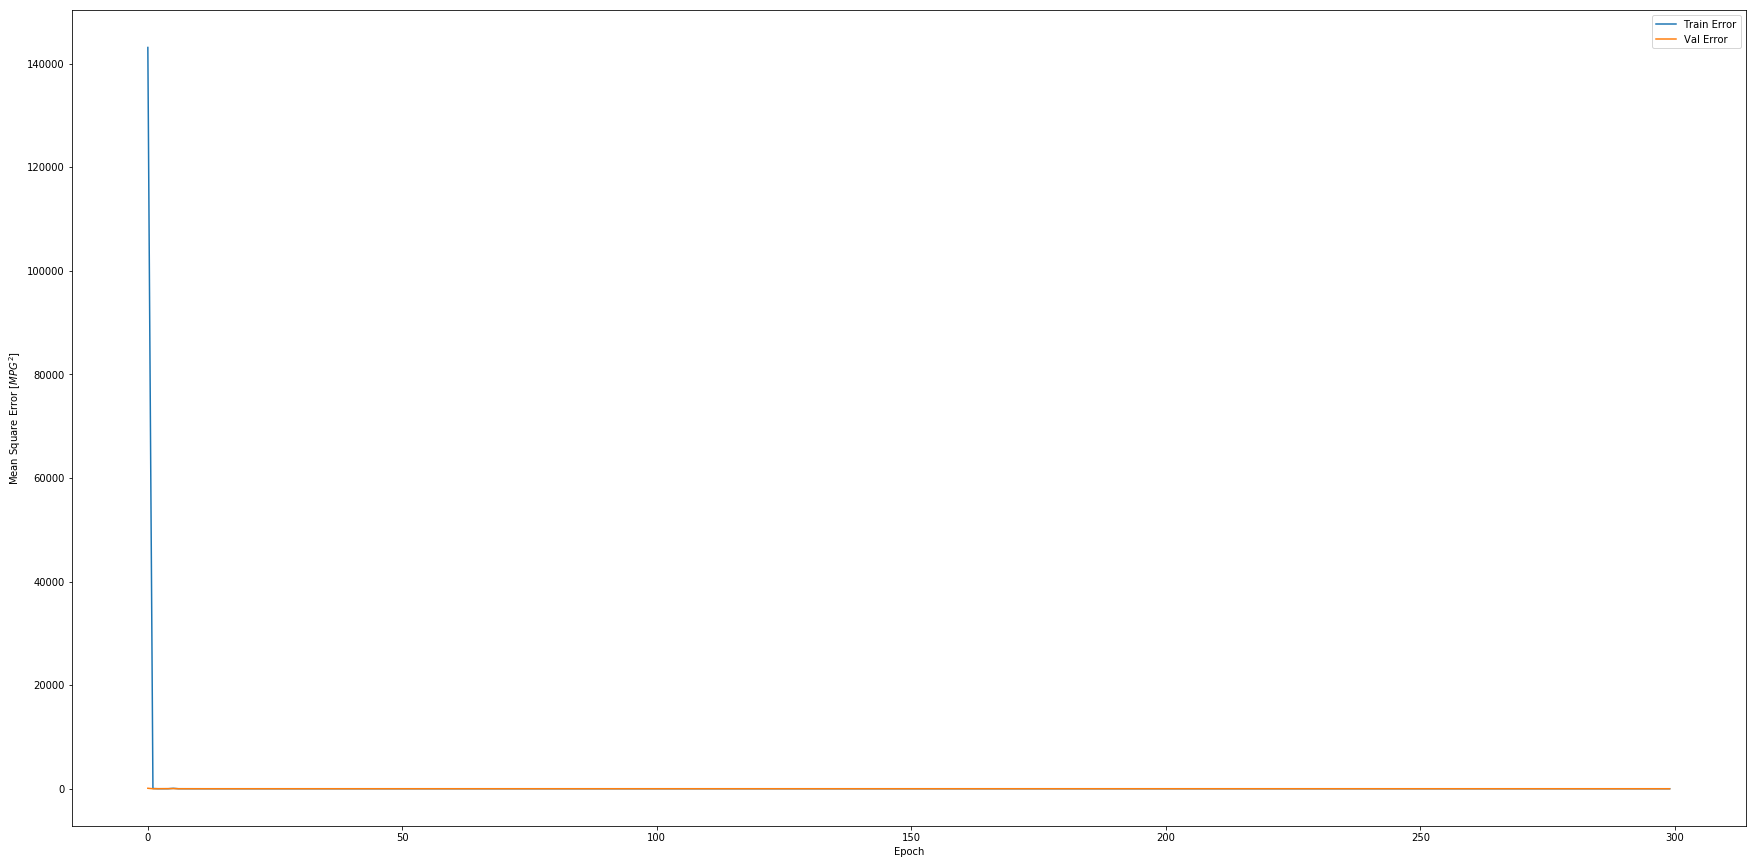

Normalizing test set...
Evaluating model...
924/924 [==============================] - 0s 358us/sample - loss: 0.0500 - mean_absolute_error: 0.0651 - mean_squared_error: 0.0500
0.04997889806609197 0.06511728 0.049978893
Running CNN model...
Partitioning data...
Normalizing training set...
(2156, 120, 160, 1) (2156, 2) (924, 120, 160) (924, 2)
Generating model...
Training...
Train on 1724 samples, validate on 432 samples
Epoch 1/300
1724/1724 [==============================] - 9s 5ms/sample - loss: 935.1020 - mean_absolute_error: 6.2677 - mean_squared_error: 935.1019 - val_loss: 0.1632 - val_mean_absolute_error: 0.3739 - val_mean_squared_error: 0.1632
Epoch 2/300
1724/1724 [==============================] - 3s 2ms/sample - loss: 0.0700 - mean_absolute_error: 0.2329 - mean_squared_error: 0.0700 - val_loss: 0.0317 - val_mean_absolute_error: 0.1534 - val_mean_squared_error: 0.0317
Epoch 3/300
1724/1724 [==============================] - 3s 2ms/sample - loss: 0.0155 - mean_absolute_error: 0

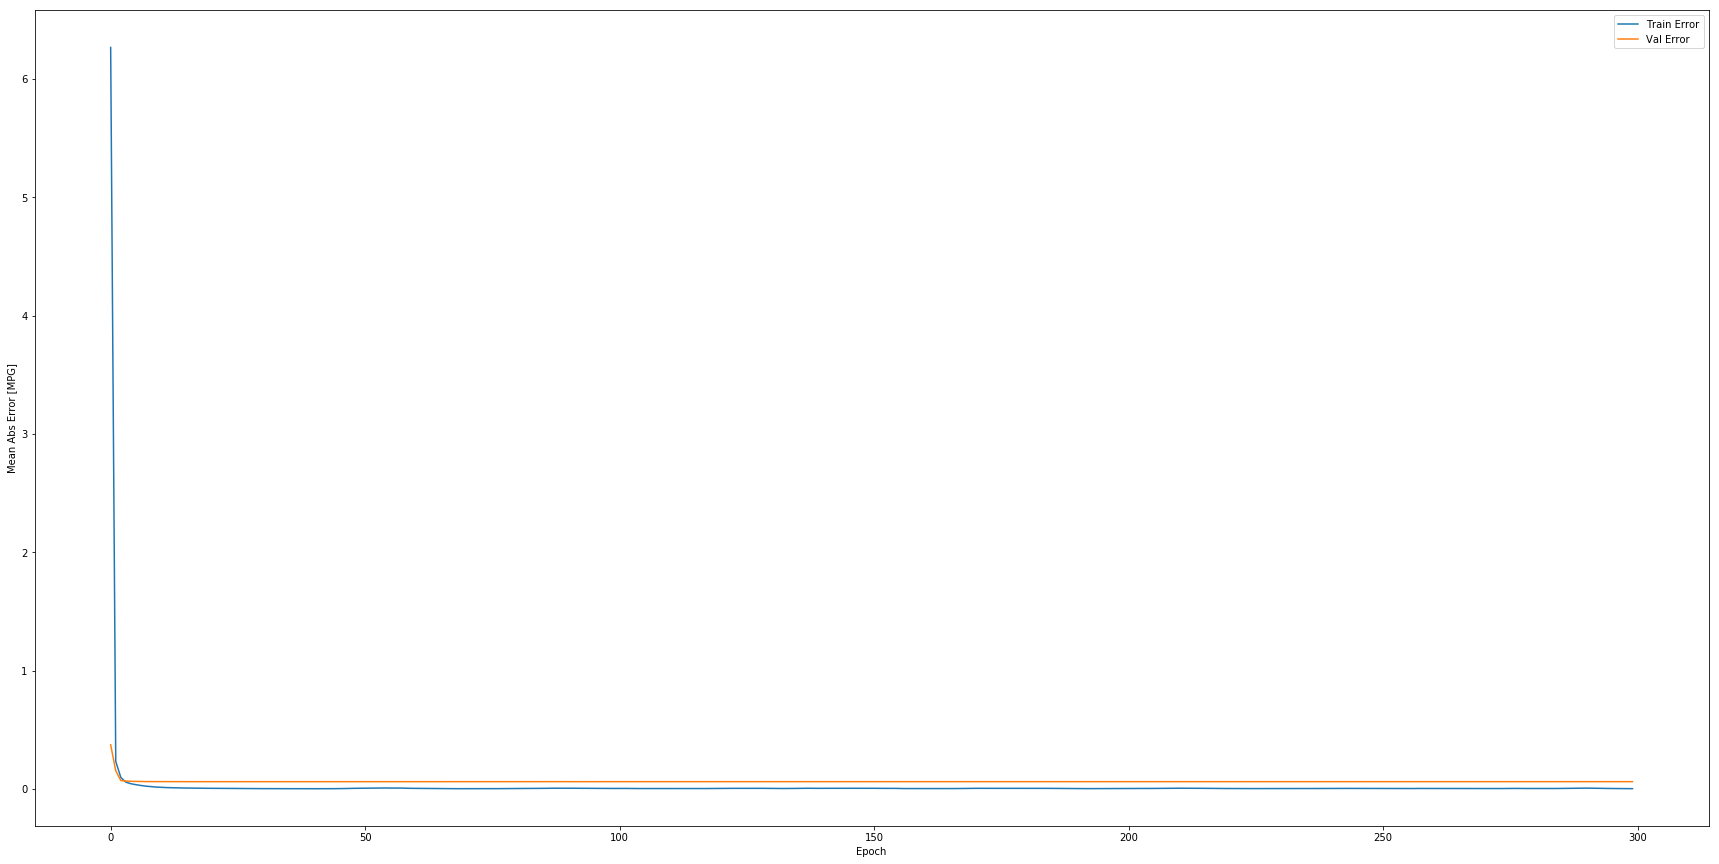

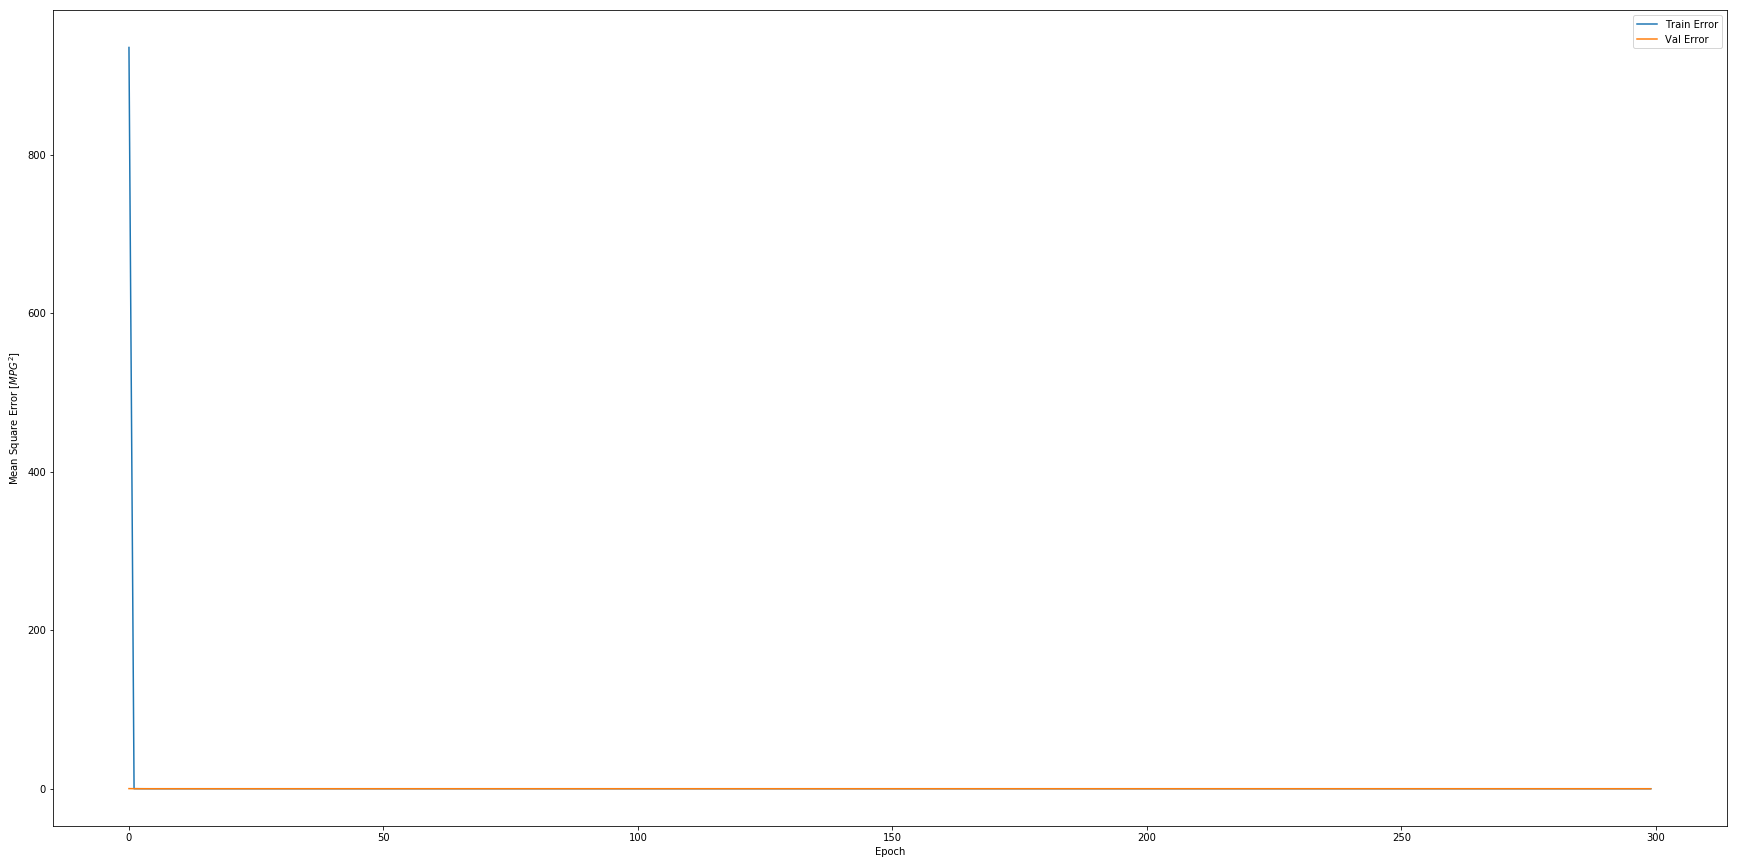

Normalizing test set...
Evaluating model...
924/924 [==============================] - 1s 1ms/sample - loss: 0.0090 - mean_absolute_error: 0.0576 - mean_squared_error: 0.0090
0.009032076825407935 0.057565324 0.009032077


In [17]:
import gc

def run_mlp(D):
  gc.collect()
  N = train(D, model='mlp')
  N.save('mlp_model.h5')
  
def run_cnn(D):
  gc.collect()
  N = train(D, model='cnn')
  N.save('cnn_model.h5')

def run():
  print('Loading dataset...')
  D = np.load('data_gray_120x160.npy', allow_pickle=True)
  print('Running MLP model...')
  run_mlp(D)
  print('Running CNN model...')
  run_cnn(D)
  
print("GPU Available: ", tf.test.is_gpu_available())
run()